<a href="https://colab.research.google.com/github/sg879/IIBProject/blob/main/Test/Variational_Infer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Variational Inference on the Test Data

## Importing Packages

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
import numpy as np
import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax
from functools import partial
import jax

In [6]:
from jax.config import config
config.update("jax_enable_x64", True)

## Load Test Data

In [7]:
testx = jnp.load('drive/MyDrive/Project/Test/Testx.npy').astype('f')
testy = jnp.load('drive/MyDrive/Project/Test/Testy.npy')
inw = jnp.load('drive/MyDrive/Project/Test/Inputwin.npy')
outw = jnp.load('drive/MyDrive/Project/Test/Outputwin.npy')

In [8]:
k = jnp.shape(testx)[0]-1
m = jnp.shape(testy)[0] - k - 1
binw = inw/k
timex = jnp.linspace(0.0, k*binw, k+1)
timey = jnp.linspace(0.0, (m+k)*binw, k+m+1)

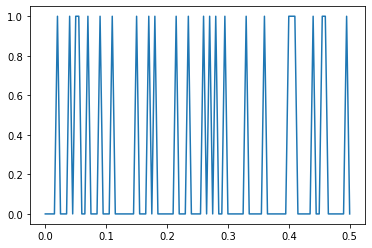

In [9]:
plt.plot(timex, testx)

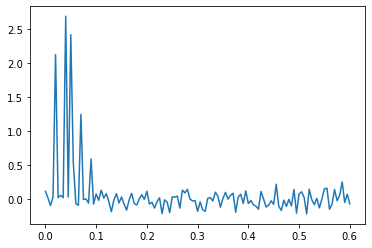

In [10]:
plt.plot(timey, testy)

## Function Definitions

### SE Prior


In [11]:
@jit
def squared_exp2(I, J, Ell, Sigma_f):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2*Ell**2.0))

In [12]:
vec_SE = jit(vmap(vmap(squared_exp2, in_axes=[None,0,None,None]),in_axes=[0,None,None,None]))

In [13]:
@jit
def root_squared_exp2(I, J, Ell, Sigma_f, Dt):
  return Sigma_f*(2/jnp.pi)**(0.25)*(Dt/Ell)**(0.5)*jnp.exp(-(I-J)**2/Ell**2)

In [14]:
vec_SE_root = jit(vmap(vmap(root_squared_exp2, in_axes=[None,0,None,None, None]),in_axes=[0,None,None,None, None]))

### Cholesky Check

In [323]:
@jit
def broke_Chol(Symmetric_Matrix):
  F_size = jnp.shape(Symmetric_Matrix)[0]
  return jnp.linalg.cholesky(Symmetric_Matrix + 10.0**(-2.0)*jnp.eye(F_size))

In [18]:
@jit
def good_Chol(Symmetric_Matrix):
  return jnp.linalg.cholesky(Symmetric_Matrix)

### Variational Bound (ELBO)

#### KL Divergence

In [22]:
@jit
def kl_div(L_matrix, Prior_cov_root,  Mu_prior, Param_vu):
  # Not including m/2 term as not being optimised over
  return jnp.sum(jnp.log(jnp.diag(L_matrix))) + 0.5*(jnp.linalg.norm(L_matrix)**2) + \
            0.5*(jnp.linalg.norm(jnp.linalg.lstsq(Prior_cov_root, Mu_prior)[0] - Param_vu)**2)

In [23]:
jax.devices()

In [24]:
jax.device_count()

1

#### Log Multivariate Gaussian PDF

In [25]:
@jit
def logmultivariate_normal(Input, Mean, Covariance_Matrix):
  # Excluding the sqrt(2*pi)**k to avoid overflow
  Diff = Input-Mean
  return -0.5*((Diff.T@jnp.linalg.lstsq(Covariance_Matrix, Diff)[0]) + jnp.log(jnp.linalg.det(Covariance_Matrix)))

In [26]:
#%timeit logmultivariate_normal(jnp.zeros((10000,)), jnp.zeros((10000,)), jnp.eye(10000))

In [27]:
vec_lognorm = jit(vmap(logmultivariate_normal, in_axes = [0, None, None]))

In [28]:
vec_lognorm(jnp.vstack((jnp.ones((10,)), jnp.zeros((10,)))), jnp.zeros((10,)), jnp.eye(10))

DeviceArray([-5., -0.], dtype=float64)

#### Expected Log Likelihood

In [29]:
@jit
def Log_Likely(Sampled_f, Truex, Truey, Sigma_n):

  K = jnp.shape(Truex)[0] - 1
  M = jnp.shape(Truey)[0] - K -1
  
  # Pad input and filter
  X_pad = jnp.hstack((Truex, jnp.zeros((M,))))
  F_pad = jnp.hstack((Sampled_f, jnp.zeros((K,))))

  # Compute the FFTs
  X_fft = jnp.fft.fft(X_pad)
  F_fft = jnp.fft.fft(F_pad)

  # Elementwise multiplication
  FFTmul = jnp.multiply(X_fft, F_fft)

  # Make mean
  Y_mean = jnp.real(jnp.fft.ifft(FFTmul))

  return jsc.stats.multivariate_normal.logpdf(Truey, Y_mean, Sigma_n*jnp.eye(M+K+1))

In [30]:
Log_Likely(jnp.ones((21,)), timex.flatten(), timey.flatten(), 0.05)

DeviceArray(-29424.24175997, dtype=float64)

In [31]:
vec_loglikely = jit(vmap(Log_Likely, in_axes = [1, None, None, None]))

In [329]:
#@partial(jit, static_argnums=(0,1))
def Exp_qf(Number_f, Num_Inducing, Subkey, Truex, Truey, Knn, Knm, Kmm, Inducing_Mean, Prior_cov_root, L_matrix, Sigma_n):

  
  # Sampling f
  A = Knm @ jnp.linalg.inv(Kmm)
  F_Mean = A @ Inducing_Mean
  F_Covariance = Knn + A @ (Prior_cov_root @ L_matrix @ L_matrix.T @ Prior_cov_root
                            - Kmm) @ A.T

  
  print("Inducing_Mean is: %s \n" % jnp.isnan(Inducing_Mean).any())
  print("A is: %s \n" % jnp.isnan(A).any())
  print("F_Mean is: %s \n" % jnp.isnan(F_Mean).any())
  print("F_Covariance is: %s \n" % jnp.isnan(F_Covariance).any())


  F_size = jnp.shape(F_Covariance)[0]
   # Cholesky f covariance
  F_Cholesky = lax.cond(jnp.isnan(jnp.linalg.cholesky(F_Covariance)).any(), broke_Chol, jnp.linalg.cholesky, F_Covariance)
  
  print("F_Cholesky is: %s \n" % jnp.isnan(F_Cholesky).any())

  #Sampled_f = random.multivariate_normal(Subkey, F_Mean, F_Covariance, shape = (Number_f,), method = 'svd').T
  Sampled_f = F_Mean.reshape((F_size, 1)) + F_Cholesky@random.normal(Subkey, (F_size, Number_f))

  return F_Covariance, jnp.mean(vec_loglikely(Sampled_f, Truex, Truey, Sigma_n), axis = None)

#### ELBO

In [330]:
#@partial(jit, static_argnums=(0,1))
def ELBO(Number_f, Num_Inducing, Subkey, Inducing_Points, L_Arr, Param_vu, 
          Mu_prior, Ell, Sigma_f, Sigma_n, Truex, Truey, Dt, F_locs):
  L_matrix = L_fill(L_Arr, Num_Inducing)

  Knn = vec_SE(F_locs, F_locs, Ell, Sigma_f)
  Knm = vec_SE(F_locs, Inducing_Points, Ell, Sigma_f)
  Kmm = vec_SE(Inducing_Points, Inducing_Points, Ell, Sigma_f)
  Prior_cov_root = vec_SE_root(Inducing_Points, Inducing_Points, Ell, Sigma_f, Dt)

  print("Ell is: %s \n" % Ell)
  print("Prior_cov_root is: %s \n" % jnp.isnan(Prior_cov_root).any())

  Inducing_Mean = Prior_cov_root @ Param_vu

  print("Inducing_Mean is: %s \n" % jnp.isnan(Inducing_Mean).any())

  F_Covariance, One_Part = Exp_qf(Number_f, Num_Inducing, Subkey, Truex, Truey, Knn, Knm, Kmm,
                    Inducing_Mean, Prior_cov_root, L_matrix, Sigma_n)

  Two_Part = kl_div(L_matrix, Prior_cov_root,  Mu_prior, Param_vu)

  return F_Covariance, One_Part - Two_Part


In [319]:
grad_elbo = grad(ELBO, argnums = jnp.arange(3, 10))

### Make Lower Triangle from L

In [105]:
@partial(jit, static_argnums=(1,))
def L_fill(L_arr, Num_Inducing):
  L_mat = jnp.zeros((Num_Inducing, Num_Inducing))
  mask = np.tri(Num_Inducing, dtype=bool)
  L_mat = L_mat.at[mask].set(L_arr)
  return L_mat